In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from time import time
from cv2.ximgproc import guidedFilter

In [2]:
def show_img(img, gray=True, splt=111, title="Image",axis="off", in_cv2=False):
    if in_cv2:
        show_cv2_img(img)
        return
    
    if type(splt) == int:
        plt.subplot(splt)
    else:
        plt.subplot(*splt)
    
#     plt.subplot(splt)
    plt.axis(axis)
    plt.title(title)
    if gray:
        plt.imshow(img, "gray")
    else:
        plt.imshow(img)

def show_imgs(*args,grid=None,gray=True, titles=None,save=None, bgr=False):
    grid = grid or (len(args), 1)
    n = len(args)
    if len(args) == 2:
        plt.subplots_adjust(top=2, right=2)
        grid = (1,2)
    else:
        plt.subplots_adjust(top=grid[0], right=grid[1])
#     print(grid)
    if not titles:
        titles = ["image"] * len(args) 
    for i, (img, title) in enumerate(zip(args, titles)):
        splt= grid+(i+1,)
        if bgr:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        show_img(img, gray=gray, splt=splt, title=title)
    if save:
        plt.savefig(save)

In [15]:
def resize_image(img, limit_w = 250, limit_h = 250):
    h = img.shape[0]
    w = img.shape[1]
    ratio = 1
    if w>h:
        if w > limit_w:
            ratio = limit_w / w
    else:
        if h> limit_h:
            ratio = limit_h / h
    print(ratio)
    return cv2.resize(img, None, fx=ratio, fy=ratio)

In [4]:
def noisy(image):
    try:
        row,col= image.shape
        chan=1
    except:
        row,col,chan = image.shape 
    mean = 0
    var = 10
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col,chan))
    if chan ==1:
        gauss = gauss.reshape(row,col)
    else:
        gauss = gauss.reshape(row,col,chan)
    noisy = image + gauss
    return noisy.astype(np.uint8)

0.8333333333333334
(250, 250, 3)


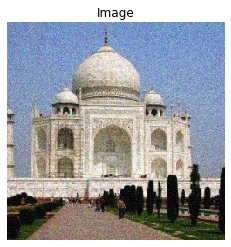

In [51]:
img_bgr = cv2.imread('../images/taj.jpg')
img_bgr = resize_image(img_bgr)
print(img_bgr.shape)
img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
img_rgb = np.copy(img_bgr[:,:,::-1])
show_img(img_rgb)

In [27]:
img_ref = cv2.imread('../images/pots_flash.jpg')
img_src = cv2.imread('../images/pots_no_flash.jpg')

img_ref = resize_image(img_ref)
img_src = resize_image(img_src)
img_rgb = img_src

0.32299741602067183
0.32299741602067183


250 2


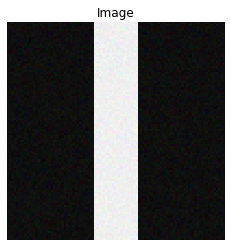

In [143]:
img_rgb = np.zeros((100, 100,3), dtype=np.uint8) + 15
img_rgb[:, 40:60] = 240
img_rgb_dn = img_rgb.copy()
img_rgb = noisy(img_rgb)
print(np.amax(img_rgb), np.amin(img_rgb))
show_img(img_rgb)
# img_rgb[45, 85]

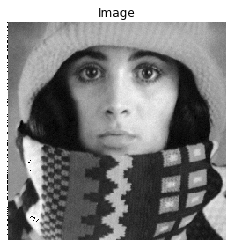

In [11]:
img_noise = noisy(img_gray)
show_img(img_noise.astype(np.uint8),gray=True)

In [43]:
class PropagationFilter:
    
    def __init__(self):
        self.dis = None
        self.D_v = None
        self.D_h = None
        self.disq1 = None
        self.disq2 = None
        self.disq3 = None
        self.disq4 = None

    @staticmethod
    def gaussian(x,y,sigma):
        return np.exp(-np.power(x-y,2)/(2*sigma**2))
    
  
    def weight(self, img, d, sigma, ts_v,ts_h):
        """
        For, window sizes <=11, this weight method run fast
        
        """
        ind = d // 2

        dif = (img - img[ind, ind])**2

        w = np.exp( -dif / (2*sigma**2))
        
        # adjacent pixels
        w[ind,ind+1] *= w[ind, ind+1]
        w[ind+1,ind] *= w[ind+1, ind]
        w[ind-1,ind] *= w[ind-1, ind]
        w[ind,ind-1] *= w[ind, ind-1]

        #pixels in same row
        
        for i in range(ind+2,d):
            w[ind,i] *= w[ind,i-1]*ts_h[ind, i-1]

        for i in range(ind-2,-1,-1):
            w[ind,i] *= w[ind,i+1]*ts_h[ind, i]

        #pixels in same column
        for i in range(ind+2,d):
            w[i,ind] *= w[i-1,ind]*ts_v[i-1, ind]

        for i in range(ind-2,-1,-1):
            w[i,ind] *= w[i+1,ind]*ts_v[i, ind]

        # Q1    

        for i in range(ind-1,-1,-1):
            for j in range(ind+1,d):
                if self.dis[i,j]==1:
                    w[i,j] *= w[i+1,j]*ts_v[i,j]
                else:
                    w[i,j] *= w[i,j-1]*ts_h[i,j-1]

        # Q2

        for i in range(ind-1,-1,-1):
            for j in range(ind-1,-1,-1):
                if self.dis[i,j]==1:
                    w[i,j] *= w[i+1,j]* ts_v[i,j]
                else:
                    w[i,j] *= w[i,j+1] *ts_h[i,j]
        # Q3
        for i in range(ind+1,d):
            for j in range(ind-1,-1,-1):
                if self.dis[i,j]==1:
                    w[i,j] *= w[i-1,j]* ts_v[i-1,j]
                else:
                    w[i,j] *= w[i,j+1]* ts_h[i,j]

        # Q4
        for i in range(ind+1,d):
            for j in range(ind+1,d):
                if self.dis[i,j]==1:
                    w[i,j] *= w[i-1,j]*ts_v[i-1,j]
                else:
                    w[i,j] *= w[i,j-1]*ts_h[i,j-1]
        return w

    def weight_dev(self,img,d,sigma, ts_v,ts_h):
        """
        For window sizes > 11, this method runs fast
        """
        ind = d //2

        dif = (img - img[ind, ind])**2

        w = np.exp( -dif / (2*sigma**2))
#         print(w.shape)

        # adjacent pixels
        w[ind,ind+1] *= w[ind, ind+1]
        w[ind+1,ind] *= w[ind+1, ind]
        w[ind-1,ind] *= w[ind-1, ind]
        w[ind,ind-1] *= w[ind, ind-1]

        #pixels in same row
        for i in range(ind+2,d):
            w[ind,i] *= w[ind,i-1]*ts_h[ind, i-1]

        for i in range(ind-2,-1,-1):
            w[ind,i] *= w[ind,i+1]*ts_h[ind, i]

        #pixels in same column
        for i in range(ind+2,d):
            w[i,ind] *= w[i-1,ind]*ts_v[i-1, ind]

        for i in range(ind-2,-1,-1):
            w[i,ind] *= w[i+1,ind]*ts_v[i, ind]


        # Q1 & Q2 
        for i in range(ind-1,-1,-1):
            dis1 = self.dis[i]
            w[i, dis1] *= w[i+1, dis1] * ts_v[i,dis1]
            w[i, self.disq1[i]] *= w[i, self.disq1[i]-1] * ts_h[i, self.disq1[i]-1]
            w[i, self.disq2[i]] *= w[i, self.disq2[i]+1] * ts_h[i, self.disq2[i]]

        
        # Q3 & Q4
        for i in range(ind+1, d):
            dis1 = self.dis[i]
            w[i, dis1] *= w[i-1, dis1] * ts_v[i-1, dis1]
            w[i, self.disq3[i]] *= w[i, self.disq3[i]+1] * ts_h[i, self.disq3[i]] 
            w[i, self.disq4[i]] *= w[i, self.disq4[i]-1] * ts_h[i, self.disq4[i]-1]
        
        return w


    def set_dis(self, d):
        self.dis = np.zeros((d,d),dtype=bool)
        nx, ny = (1, 1)
        x = np.linspace(1, d, d)
        y = np.linspace(1, d, d)
        xv, yv = np.meshgrid(x, y)
        x = np.abs(xv - np.ceil(d/2))
        m = x + x.T
        self.dis[m%2==1] = 1
        ind = np.ceil((d-1)/2).astype(np.int)
        self.dis[ind,:] = 0 
        self.dis[:,ind] = 1
        self.dis[:,ind] = False
        self.disq1 = []
        self.disq2 = []
        self.disq3 = []
        self.disq4 = []
        for i, row in enumerate(self.dis):
            dis0 = np.argwhere(row==0).ravel()
            self.disq1.append(dis0[dis0>ind])
            self.disq2.append(dis0[dis0<ind])
            self.disq3.append(dis0[dis0<ind])
            self.disq4.append(dis0[dis0>ind])
        
        
    
    def calc_ts(self,img,sigma=50): 
        self.D_v = np.exp((-np.diff(img, axis=0)**2) / (2 * sigma**2))
        self.D_h = np.exp((-np.diff(img, axis=1)**2) / (2 *sigma**2))

    def filt(self, img, d=5, sig=50):
        try:
            h,w,c = img.shape[:]
        except:
            h,w = img.shape[:]
            c =1
        self.set_dis(2*d+1)
#     #     dis = dis.astype(bool)
#         weights =np.zeros((h,w,c,2*d+1,2*d+1))
        pad_img = np.pad(img,((d,d), (d,d), (0,0)),'edge').astype(np.float64)
        self.calc_ts(pad_img)
        out = np.zeros(img.shape)
#         print(c)
        for i in range(d,h+d):
#             print(i,end=" ")
            for j in range(d,w+d):
                for k in range(c):
                    ts_v = self.D_v[i-d:i+d, j-d:j+d+1, k]
                    ts_h = self.D_h[i-d:i+d+1, j-d:j+d, k]
                    wei = self.weight_dev(pad_img[i-d:i+d+1,j-d:j+d+1, k],d*2+1, sig, ts_v, ts_h)
#                     weights[i-d, j-d, k, :, :] = wei
                    out[i-d, j-d, k] = (wei * pad_img[i-d:i+d+1,j-d:j+d+1, k]).sum() / wei.sum()
        return out.astype(np.uint32)
    
    
    def joint_filter(self, img_ref, img_src, d=5,sig=50):
        try:
            h,w,c = img_src.shape[:]
        except:
            h,w = img_src.shape[:]
            c =1
        self.set_dis(2*d+1)
        pad_img = np.pad(img_src,((d,d), (d,d), (0,0)),'edge').astype(np.float64)
        pad_img_r = np.pad(img_ref, ((d,d), (d,d), (0,0)),'edge').astype(np.float64) 
        self.calc_ts(pad_img_r)
        out = np.zeros(img_src.shape)
        for i in range(d,h+d):
            print(i,end=" ")
            for j in range(d,w+d):
                for k in range(c):
                    ts_v = self.D_v[i-d:i+d, j-d:j+d+1, k]
                    ts_h = self.D_h[i-d:i+d+1, j-d:j+d, k]
#                     print(i,j,k)
                    wei = self.weight_dev(pad_img_r[i-d:i+d+1,j-d:j+d+1, k],d*2+1, sig, ts_v, ts_h)
#                     weights[i-d, j-d, k, :, :] = wei
                    out[i-d, j-d, k] = (wei * pad_img[i-d:i+d+1,j-d:j+d+1, k]).sum() / wei.sum()
        
        return out.astype(np.uint32)

In [48]:
def bilateral_filter(img, sig_c=40, sig_s=30):
    out = cv2.bilateralFilter(img, 20, sig_c, sig_s)
    return out

def guided_filter(img,r=4, eps=(0.2*255)**2,guide=None):
    if guide is None:
        guide = img.copy()
    return guidedFilter(guide, img, r, eps)
    

### Propagation Filter 

In [55]:
print(img_rgb.shape)
start = time()
weights = []
pfilter = PropagationFilter()
out = pfilter.filt(img_rgb,d=5, sig=20)
end = time()
print('\n', end - start, " seconds")

(250, 250, 3)

 51.35585832595825  seconds


### Joint Propagation Filter

In [42]:
print(img_rgb.shape)
start = time()
weights = []
pfilter = PropagationFilter()
out = pfilter.joint_filter(img_ref, img_rgb, d=3, sig=5)
end = time()
print('\n', end - start, " seconds")

(228, 250, 3)
3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 
 30.92186999320984  seconds


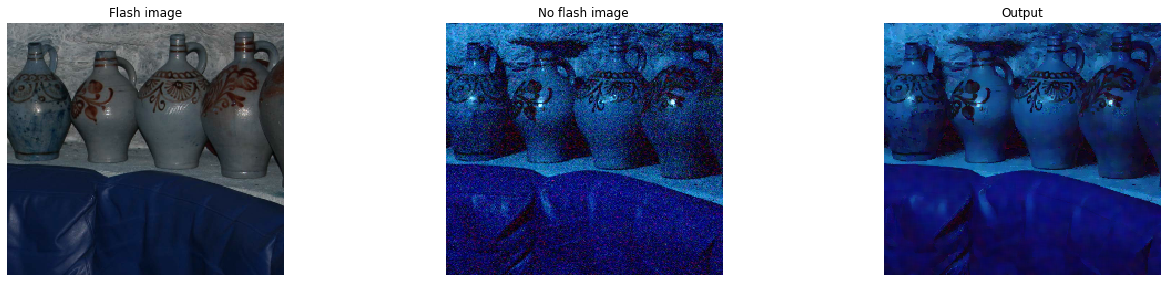

In [44]:
show_imgs(img_ref, img_src, out, grid=(1,3), titles=["Flash image", "No flash image", "Output"])

In [37]:
print(img_rgb.shape)
# start = time()
weights = []
pfilter = PropagationFilter()
for d in [3,4,5,6,7,8,9,10,11]:
    start = time()
    out = pfilter.filt(img_rgb,d)
    end = time()
    print(d, end - start, " seconds")

(225, 226, 3)
3 25.69778609275818  seconds
4 35.448315143585205  seconds
5 44.51539635658264  seconds
6 49.49516558647156  seconds
7 57.88060402870178  seconds
8 65.6760196685791  seconds
9 77.13273429870605  seconds
10 91.16813898086548  seconds
11 93.08504295349121  seconds


In [ ]:
print(weights[40, 50, 1, 5, 6])
print(weights[40, 52, 1, 5, 3])
print(weights[40, 50, 1, 4, 7])
print(weights[39, 52, 1, 6, 3])
print(weights[40,50,1])

In [56]:
img_blf = bilateral_filter(img_rgb)
img_gui = guided_filter(img_rgb, r=4,eps=(0.04*255)**2)

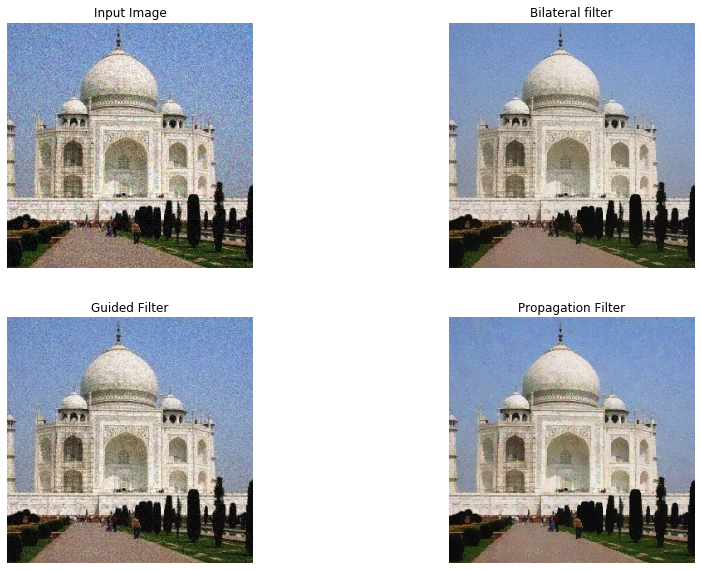

In [57]:
show_imgs(img_rgb, img_blf, img_gui, out, grid=(2,2), gray=False, titles=["Input Image", "Bilateral filter", "Guided Filter", "Propagation Filter"])

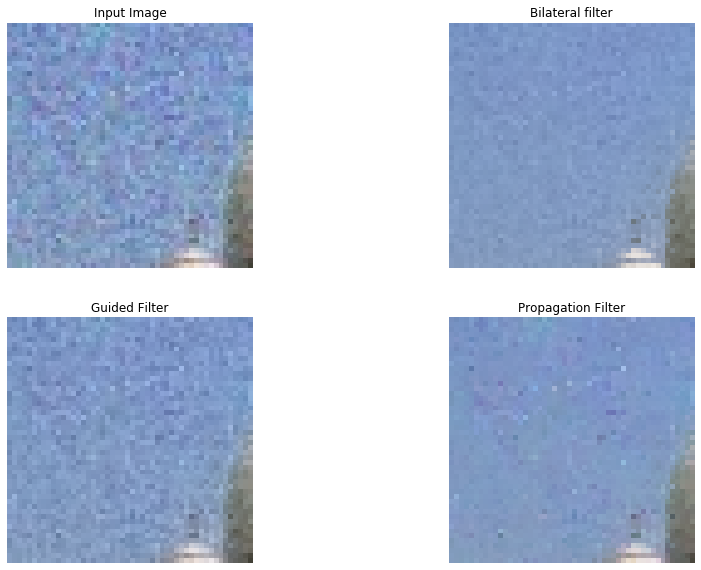

In [58]:
x = 30
y = 30
show_imgs(img_rgb[x:x+50, y:y+50], img_blf[x:x+50, y:y+50], img_gui[x:x+50, y:y+50], out[x:x+50, y:y+50], grid=(2,2), gray=False, titles=["Input Image", "Bilateral filter", "Guided Filter", "Propagation Filter"])



In [13]:
img_src.shape

(706, 774, 3)

In [14]:

img_ref.shape

(706, 774, 3)